In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [56]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
# train_identity =train_identity.head(n=500)
# train_transaction = train_transaction.head(n=500)


## Preprocessing

In [147]:
def preprocess(identity, transaction):

    df = transaction.join(identity ,how='left',on='TransactionID',lsuffix='_left', rsuffix='_right')
    df.drop(inplace=True,columns=['TransactionID_left','TransactionID_right'])

    X = df.drop(columns=['isFraud'])
    y = df['isFraud']

    X_train_na_cols = X.isna().all()
        
    print('number if columns with all nulls: ', len(X.columns[X_train_na_cols]))
    X = X.drop(X.columns[X_train_na_cols], axis=1)
        
    X_train_na_cols = X.isna().any()

    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(X)
    X = pd.DataFrame(imputer.transform(X), columns=X.columns)

    X = X.apply(pd.to_numeric, errors='ignore', axis=1)

    return X, y 

X, y = preprocess(train_identity, train_transaction)

X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True, stratify=y,test_size=0.2)


zeros_index = np.where(y_train == 0)[0]
count_ones = np.count_nonzero(y_train == 1)

drop_indices = np.random.choice(X_train.index[zeros_index], size=int(X_train.shape[0] - count_ones*2), replace=False)

y_train = y_train.drop(drop_indices)
X_train = X_train.drop(drop_indices)


X_train.to_csv('edited_X_train.csv', index=False)
y_train.to_csv('edited_y_train.csv', index=False)
X_test.to_csv('edited_X_test.csv', index=False)
y_test.to_csv('edited_y_test.csv', index=False)

number if columns with all nulls:  40


In [3]:
X_train, X_test, y_train, y_test = pd.read_csv('edited_X_train.csv'),pd.read_csv('edited_X_test.csv'),pd.read_csv('edited_y_train.csv'),pd.read_csv('edited_y_test.csv')

## GWO

In [4]:
class Encoder:
    
    def __init__(self,X, y):
        self.X = X
        self.y = y
        
    def encode(self, features_vector) -> pd.DataFrame:
        return pd.get_dummies(self.X.iloc[:,np.array(features_vector).astype(bool)],dtype=float)
        
        
proc = Encoder(X_train,y_train)
# train_transaction.shape

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

class Estimator:
    def __init__(self,cv, model_generator):
        self.cv = cv
        self.model_generator = model_generator

    def get_score(self,X, y) -> float:
        return cross_val_score(self.model_generator(), X,y, cv=self.cv,scoring='balanced_accuracy')
    
    def fit(self, X, y):
        return self.model_generator().fit(X,y)

In [6]:
class GreyWolfOptimizer:
    
    def __init__(self,estimator: Estimator, encoder: Encoder):
        self.estimator = estimator
        self.encoder = encoder
        self.train_score_history_ = []
        self.features_n_history_ = []
        self.fitted_model_ = None
        self.features_n_ = None
        self.n = len(self.encoder.X.columns)

    def _init_population(self, features_n, population_size):
        population = []
        individual = []
        
        for _ in range(population_size):
            individual = np.random.random(size=features_n)
            population.append(individual)
        return population

    def run(self, iterations = 50, threshold = 0.5, population_size = 10):
        
        #Init algo
        population = self._init_population(population_size=population_size,features_n=self.n)

        bar = tqdm(range(iterations))

        for i in bar: #Epochs
            step = i * ((2-0) / iterations)
            population = sorted(population, key=lambda x: self._calculate_cost(x,threshold),reverse = True)
            self.train_score_history_.append(self._calculate_cost(population[0],threshold))
            self.features_n_history_.append(np.sum(population[0] >= threshold))
            X = population[:3] # alpha, beta, delta
            a = np.full((1, self.n), 2 - step).ravel()
            new_population = []
            for individual in population:
                r1 = np.random.random(size=self.n)
                r2 = np.random.random(size=self.n)
                A = 2 * a * r1 - a
                C = 2 * r2
                new_individual = np.full((1, self.n), 0.0).ravel()
                for x in X:
                    D = abs(C * x - individual)
                    new_x = x - A * D
                    new_individual = new_individual + new_x
                new_population.append(new_individual / 3)
            
            population = new_population

        # Best solution after n iterations
        population = sorted(population, key=lambda x: self._calculate_cost(x,threshold),reverse = True)
        X_alpha = population[0]
        self.train_score_history_.append(np.average(self._calculate_cost(X_alpha,threshold)))
        self.fitted_model_ = self.estimator.fit(self.encoder.encode(np.array(X_alpha) >= threshold),self.encoder.y)
        self.features_ = self.encoder.X.columns[X_alpha >= threshold]
        self.features_n_ = len(self.features_)
        self.features_n_history_.append(self.features_n_)


    def _calculate_cost(self, weights, threshold):
        X = self.encoder.encode(np.array(weights) >= threshold)
        y = self.encoder.y

        res =  self.estimator.get_score(X,y)
        return np.average(res)
    

## Evaluation

In [11]:
def make_test_cols_consistent(X_test,train_cols):
    cols_to_delete = set(X_test.columns).difference(set(train_cols))
    cols_to_add = set(train_cols).difference(set(X_test.columns))
        
    X_test = X_test.drop(columns=cols_to_delete)

    for feature in cols_to_add:
        new_df = pd.DataFrame(columns=[feature], data=np.zeros(shape=(len(X_test),1)))
        X_test = pd.concat((X_test,new_df),axis=1)
    return X_test

### All features

In [15]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = make_test_cols_consistent(pd.get_dummies(X_test), X_train_encoded.columns)
X_test_encoded = X_test_encoded[X_train_encoded.columns]



In [30]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score,precision_score,recall_score

model = DecisionTreeClassifier()

model.fit(pd.get_dummies(X_train_encoded), y_train)


y_pred = model.predict(X_test_encoded)

print(balanced_accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.794283179266362
0.11800275823048906
0.8074038228889426


### RFE

### GWO

In [7]:
estimator = Estimator(cv=5, model_generator = lambda: DecisionTreeClassifier())
encoder = Encoder(X_train, y_train)
GWO = GreyWolfOptimizer(estimator,encoder)

In [49]:
GWO.run(iterations=50,population_size=30)

100%|██████████| 50/50 [1:52:00<00:00, 134.40s/it]


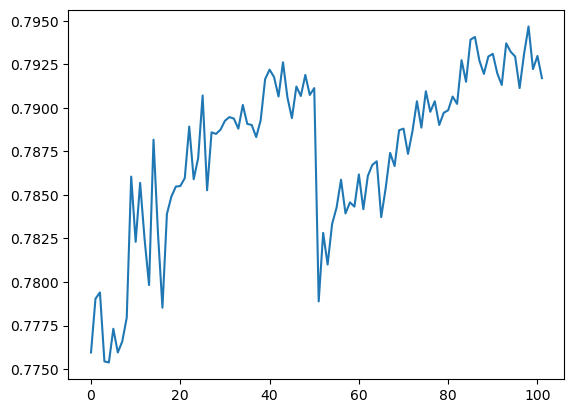

In [51]:
import matplotlib.pyplot as plt

plt.plot(GWO.train_score_history_)

In [52]:
model = GWO.fitted_model_

X_train_encoded = pd.get_dummies(X_train[GWO.features_])
X_test_encoded = make_test_cols_consistent(pd.get_dummies(X_test), X_train_encoded.columns)
X_test_encoded = X_test_encoded[X_train_encoded.columns]

In [53]:
from sklearn.metrics import balanced_accuracy_score,precision_score,recall_score

y_pred = model.predict(X_test_encoded)

print(balanced_accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.7962906892649839
0.11707706734275693
0.8156302927655457


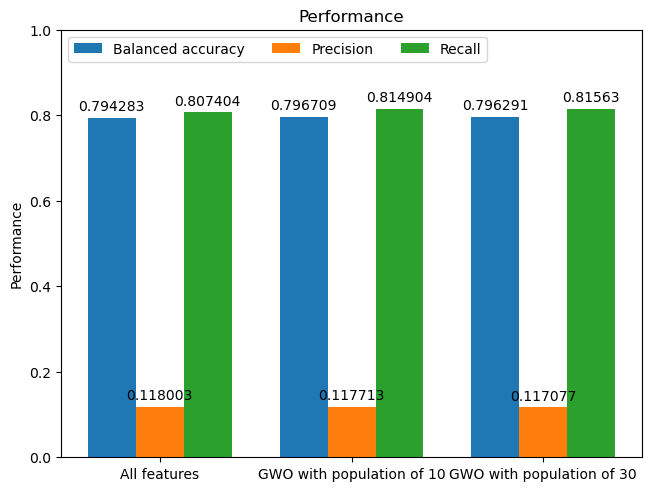

In [54]:

import matplotlib.pyplot as plt
import numpy as np

species = ("All features", "GWO with population of 10","GWO with population of 30")
penguin_means = {
    'Balanced accuracy': (0.794283179266362,0.7967086297688923,0.7962906892649839),
    'Precision': (0.11800275823048906,0.11771284775618622,0.11707706734275693),
    'Recall': (0.8074038228889426,0.8149044277764336,0.8156302927655457),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance')
ax.set_title('Performance')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()
